In [189]:
import sklearn
from sklearn.decomposition import PCA, KernelPCA

import random
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn_image as isns

sns.set_style("darkgrid")
isns.set_image(origin="upper")

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


In [82]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = Path(self.img_labels.iloc[idx]["file_path"])
        image = read_image(str(img_path))
        label = self.img_labels.iloc[idx]["class_index"]
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label


In [83]:
label_names = {0: "tree", 1:"sun", 2:"fish", 3:"bird", 4:"flower"}

In [130]:
train_dataset = CustomImageDataset("./data/train_data.csv")
test_dataset = CustomImageDataset("./data/test_data.csv")

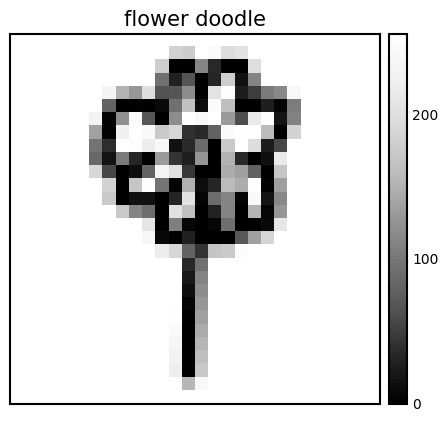

In [111]:
sample_image = random.choice(train_dataset)

ax = isns.imgplot(sample_image[0][0,:,:], cmap="Greys_r")
ax.set_title(f"{label_names[sample_image[1]]} doodle")
plt.show()

In [131]:
input_train_matrix = np.empty((len(train_dataset),) + train_dataset[0][0].shape[1:])
input_test_matrix = np.empty((len(test_dataset),) + test_dataset[0][0].shape[1:])

target_train_matrix = np.empty(len(train_dataset))
target_test_matrix = np.empty(len(test_dataset))


for idx, data_point in enumerate(train_dataset):
    input_train_matrix[idx] = data_point[0][0,:,:]
    target_train_matrix[idx] = data_point[1]

for idx, data_point in enumerate(test_dataset):
    input_test_matrix[idx] = data_point[0][0,:,:]
    target_test_matrix[idx] = data_point[1]


input_train_matrix = input_train_matrix.reshape([input_train_matrix.shape[0], -1])
input_test_matrix = input_test_matrix.reshape([input_test_matrix.shape[0], -1])

print(input_train_matrix.shape)
print(input_test_matrix.shape)
print(target_train_matrix.shape)
print(target_test_matrix.shape)

(12000, 784)
(3000, 784)
(12000,)
(3000,)


(28, 28)


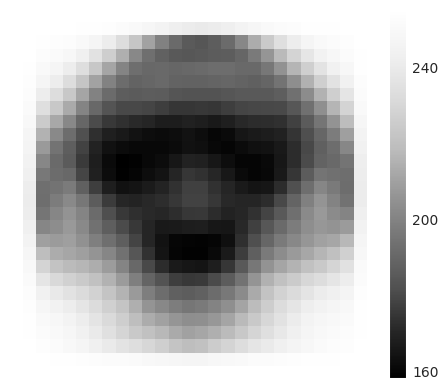

In [185]:
avgimg = np.mean(input_train_matrix, axis=0).reshape([28,28])
print(avgimg.shape)
isns.imgplot(avgimg, cmap="Greys_r")
plt.show()

In [ ]:
avgimg = np.mean(input_train_matrix, axis=0).reshape([28,28])
print(avgimg.shape)
isns.imgplot(avgimg, cmap="Greys_r")
plt.show()

[[4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


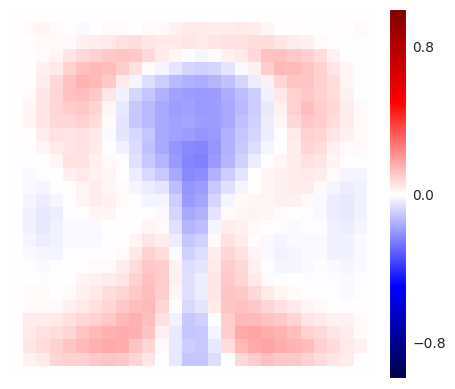

In [222]:
r = np.empty(input_train_matrix.shape[1:])
for idx, val in enumerate(input_train_matrix[0]):
    
    x = input_train_matrix[:, idx]
    y = target_train_matrix + 1 
    n = len(x)

    if y.std() != 0 and x.std() != 0:  
        r[idx] = (np.sum(x*y) - n * x.mean() * y.mean())/((n-1)*x.std()*y.std())
    else:
        r[idx] = 0

isns.imgplot(r.reshape([28,28]), cmap="seismic", vmin=-1, vmax=1)
plt.show()

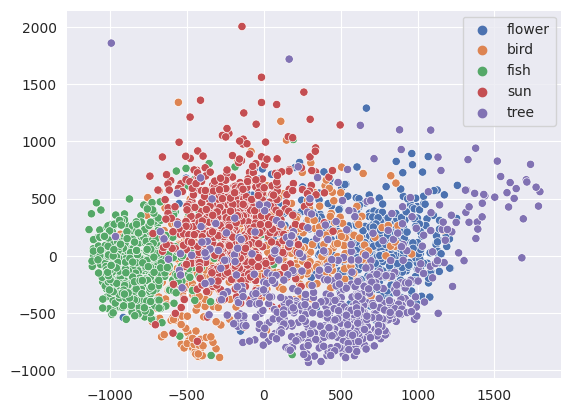

In [173]:
pca = PCA(n_components=2)
pca.fit(input_train_matrix)

test_reduced = pca.transform(input_test_matrix)

sns.scatterplot(x=test_reduced[:,0], y=test_reduced[:,1], hue=map(label_names.__getitem__, target_test_matrix), palette="deep")
plt.show()